In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Лаботраторная работа 3.1
### Интерполяция

Интерполяционный многочлен Лагранжа

In [3]:
class Lagrangian_interpolation_polynomial:
    def __init__(self, f, X) -> None:
        self.n = len(X)
        self.f = f
        self.X = X
    
    def __omega(self, x, i):
        result = 1
        for j, x_i in enumerate(self.X):
            if i != j:
                result *= (x-x_i)
        return result

    def interpolate(self, X):
        result = 0
        for i in range(self.n):
            result += self.f[i]*self.__omega(X, i)/self.__omega(self.X[i], i)
        return result 

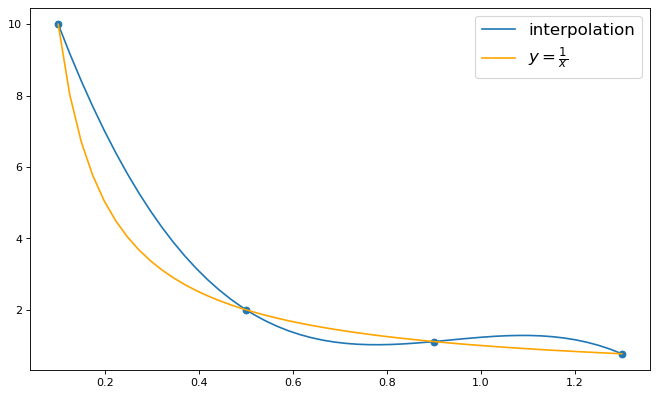

In [4]:
def y(x):
    return(1/x)

X = np.array([0.1, 0.5, 0.9, 1.3])
f = y(X)

interpolator = Lagrangian_interpolation_polynomial(f, X)
x = np.linspace(X[0], X[-1])

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X, f)
plt.plot(x, interpolator.interpolate(x), label = 'interpolation')
plt.plot(x, y(x), color = 'orange', label = r'$y = \frac{1}{x}$')
plt.legend(loc=0, prop={'size': 15})
plt.show()

Погешность в $X^* = 0.8$

In [5]:
abs(interpolator.interpolate(0.8) - y(0.8))

0.22435897435897445

Интерполяционный многочлен Ньютона

In [6]:
class Newton_interpolation_polynomial:
    def __init__(self, f, X) -> None:
        self.n = len(X)
        self.f = f
        self.X = X

        self.divided_difference = []
        self.divided_difference.append([self.f[i] for i in range(self.n)])
        for k in range(1, self.n):
            self.divided_difference.append([])
            for i in range(self.n-k):
                self.divided_difference[k].append((self.divided_difference[k-1][i]-self.divided_difference[k-1][i+1])/ \
                                                  (self.X[i]-self.X[i+k]))

    def interpolate(self, X):
        result = self.f[0]
        for k in range(1, self.n):
            # print(np.array([X-self.X[i] for i in range(self.n)]))
            # print(np.prod(np.array([X-self.X[i] for i in range(self.n)]), axis = 0))
            # print(self.divided_difference[k, 0])
            result += np.prod(np.array([X-self.X[i] for i in range(k)]), axis = 0)*self.divided_difference[k][0]
        return result

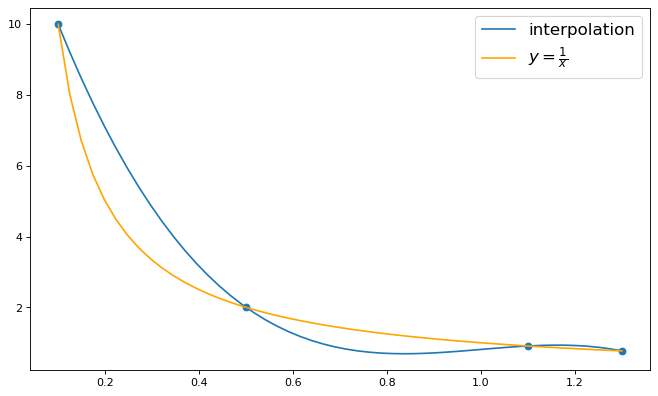

In [7]:
def y(x):
    return(1/x)

X = np.array([0.1, 0.5, 1.1, 1.3])
f = y(X)

interpolator = Newton_interpolation_polynomial(f, X)
x = np.linspace(X[0], X[-1])

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X, f)
plt.plot(x, interpolator.interpolate(x), label = 'interpolation')
plt.plot(x, y(x), color = 'orange', label = r'$y = \frac{1}{x}$')
plt.legend(loc=0, prop={'size': 15})
plt.show()

Погешность в $X^* = 0.8$

In [8]:
abs(interpolator.interpolate(0.8) - y(0.8))

0.5506993006993007

# Лаботраторная работа 3.2
### Сплайн интерполяция

In [9]:
class Cubic_interpolation_spline:
    def __init__(self, f, X) -> None:
        self.n = len(X)
        self.f = f
        self.X = X

        A = np.zeros((self.n-1, self.n-1))
        A[0, 0] = 0
        A[1, 1] = 2*(self.__h(1)+self.__h(2))
        A[1, 2] = self.__h(2)
        for i in range(2, self.n-2):
            A[i, i-1] = self.__h(i-1)
            A[i, i] = 2*(self.__h(i-1)+self.__h(i))
            A[i, i+1] = self.__h(i)
        A[-1, -2] = self.__h(-2)
        A[-1, -1] = 2*(self.__h(-2)+self.__h(-1))

        b = np.empty(self.n-1)
        b[0] = 0
        b[1] = 3*(((self.f[2]-self.f[1])/self.__h(2))-((self.f[1]-self.f[0])/self.__h(1)))
        for i in range(2, self.n-1):
            b[i] = 3*(((self.f[i+1]-self.f[i])/self.__h(i+1))-((self.f[i]-self.f[i-1])/self.__h(i)))
        b[-1] = 3*(((self.f[-1]-self.f[-2])/self.__h(-1))-((self.f[-2]-self.f[-3]/self.__h(-2))))
        
        self.c = np.empty(self.n-1)
        self.c[0] = 0
        self.c[1:] = np.linalg.solve(A[1:, 1:], b[1:])
        self.a = np.array([None]*(self.n-1))
        self.b = np.array([None]*(self.n-1))
        self.d = np.array([None]*(self.n-1))
        for i in range(self.n-2):
            self.a[i] = self.f[i]
            self.b[i] = ((self.f[i+1]-self.f[i])/self.__h(i+1)-(1/3)*self.__h(i+1)*(self.c[i+1]+2*self.c[i]))
            self.d[i] = (self.c[i+1]-self.c[i])/(3*self.__h(i+1))
        self.a[-1] = self.f[-2]
        self.b[-1] = ((self.f[-1]-self.f[-2])/self.__h(self.n-1))-(2/3)*self.__h(self.n-1)*self.c[-1]
        self.d[-1] = -self.c[-1]/(3*self.__h(self.n-1))

    def __h(self, i):
        return self.X[i]-self.X[i-1]

    def __interpolate_at_point(self, x):
        if x < self.X[0] or self.X[-1] < x:
            return None
        for i in range(len(self.X)-1):
            if self.X[i] <= x and x <= self.X[i+1]:
                return self.a[i]+self.b[i]*(x-self.X[i])+self.c[i]*(x-self.X[i])**2+self.d[i]*(x-self.X[i])**3
    
    def interpolate(self, x):
        if type(x) is float:
            return self.__interpolate_at_point(x)
        else:
            result = len(x)*[None]
            for i in range(len(x)):
                result[i] = self.__interpolate_at_point(x[i])
            return np.array(result)

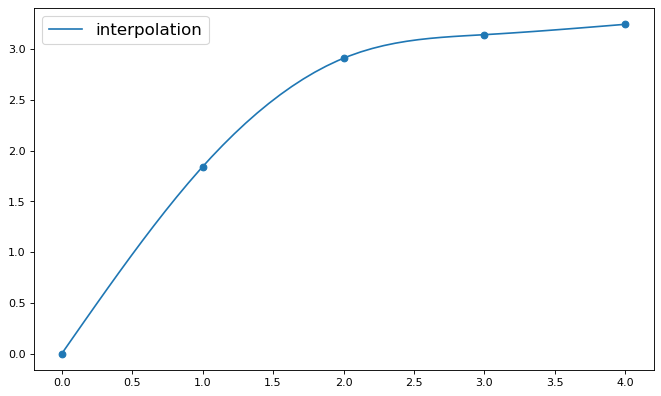

In [10]:
X = np.array([0.1, 0.5, 0.9, 1.3, 1.7])
f = np.array([10, 2, 1,1111, 0.76923, 0.58824])

X = np.array([0, 1, 2, 3, 4])
f = np.array([0.0, 1.8415, 2.9093, 3.1411, 3.2432])

interpolator = Cubic_interpolation_spline(f, X)
x = np.linspace(X[0], X[-1])

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X, f)
plt.plot(x, interpolator.interpolate(x), label = 'interpolation')
plt.legend(loc=0, prop={'size': 15})
plt.show()

Значение в $X^* = 0.8$

In [11]:
interpolator.interpolate(0.8)

1.516354742857143

# Лабораторная работа 3.3
### МНК

In [12]:
class Linear_least_squares:
    def __init__(self, x, y):
        n = len(x)
        A = np.array([[n+1, sum(x)],
                      [sum(x), sum(x**2)]])
        b = np.array([sum(y), sum(y*x)])
        self.a = np.linalg.solve(A, b)
    def approximate(self, x):
        return self.a[0]+self.a[1]*x

class Parabolic_least_squares:
    def __init__(self, x, y):
        n = len(x)
        A = np.array([[n+1, sum(x), sum(x**2)],
                      [sum(x), sum(x**2), sum(x**3)],
                      [sum(x**2), sum(x**3), sum(x**4)]])
        b = np.array([sum(y), sum(y*x), sum(y*x**2)])
        self.a = np.linalg.solve(A, b)
    def approximate(self, x):
        return self.a[0]+self.a[1]*x+self.a[2]*x**2

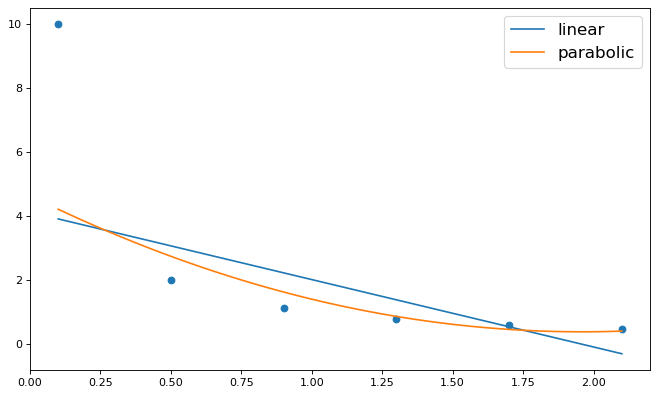

In [13]:
x = np.array([0.1, 0.5, 0.9, 1.3, 1.7, 2.1])
y = np.array([10, 2.0, 1.1111, 0.76923, 0.58824, 0.47619])

linear = Linear_least_squares(x, y)
parabolic = Parabolic_least_squares(x, y)


plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(x, y)
plot_x = np.linspace(x[0], x[-1], 50)
plt.plot(plot_x, linear.approximate(plot_x), label = 'linear')
plt.plot(plot_x, parabolic.approximate(plot_x), label = 'parabolic')
plt.legend(loc=0, prop={'size': 15})
plt.show()

# Лабораторная работа 3.4
### Численное дифференцирование

In [31]:
def first_derivative_first_order_left(X, Y, x):
    for i in range(len(X)):
        if x >= X[i] and x < X[i+1]:
            return (Y[i]-Y[i-1])/(X[i]-X[i-1])

def first_derivative_first_order_right(X, Y, x):
    for i in range(len(X)):
        if x >= X[i] and x < X[i+1]:
            return (Y[i+1]-Y[i])/(X[i+1]-X[i])

def first_derivative_second_order(X, Y, x):
    for i in range(len(X)):
        print()
        if x >= X[i] and x < X[i+1]:
            return (Y[i+1]-Y[i])/(X[i+1]-X[i])+(((Y[i+2]-Y[i+1])/(X[i+2]-X[i+1])-(Y[i+1]-Y[i])/(X[i+1]-X[i]))/(X[i+2]-X[i]))*(2*x-X[i]-X[i+1])

def second_derivative_second_order(X, Y, x):
    for i in range(len(X)):
        if x >= X[i] and x < X[i+1]:
            return 2*((Y[i+2]-Y[i+1])/(X[i+2]-X[i+1])-(Y[i+1]-Y[i])/(X[i+1]-X[i]))/(X[i+2]-X[i])

In [37]:
X = np.array([1.0, 1.5, 2.0, 2.5, 3.0])
Y = np.array([2.0, 2.1667, 2.5, 2.9, 3.3333])
x = 2

print(f'Первая левосторонняя производная первого порядка точности в точке {x}: {first_derivative_first_order_left(X, Y, x)}')
print(f'Первая правосоронняя производная первого порядка точности в точке {x}: {first_derivative_first_order_right(X, Y, x)}')
print(f'Первая производная второго порядка точности в точке {x}: {first_derivative_second_order(X, Y, x)}')
print(f'Вторая производная второго порядка точности в точке {x}: {second_derivative_second_order(X, Y, x)}')

Первая левосторонняя производная первого порядка точности в точке 2: 0.6665999999999999
Первая правосоронняя производная первого порядка точности в точке 2: 0.7999999999999998
Первая производная второго порядка точности в точке 2: 0.7666999999999997
Вторая производная второго порядка точности в точке 2: 0.13320000000000043


# Лабораторная работа 3.5
### Численное интегрирование

In [100]:
def rectangle_integration(f, x_0, x_k, h):
    x = np.arange(x_0, x_k+h, h)
    return h*sum([f((x[i]+x[i+1])/2) for i in range(len(x)-1)])

def trapezoidal_integration(f, x_0, x_k, h):
    x = np.arange(x_0, x_k+h, h)
    F = h*(f(x_0)/2+f(x_k)/2)
    return F+h*sum([f(x[i]) for i in range(1, len(x)-1)])

def simpson_integration(f, x_0, x_k, h):
    x = np.arange(x_0, x_k+h, h)
    F = (h/3)*(f(x_0)+f(x_k))
    return (h/3)*(sum([4*f(x[i])+2*f(x[i+1]) for i in range(1, len(x)-2, 2)])+4*f(x[-2]))+F

def runge_romberg_richardson_refinement(F_h, F_kh, k, p):
    return F_h+(F_h-F_kh)/(k**p-1)

In [101]:
def y(x):
    return x/(3*x+4)**2

x_0 = -1
x_k = 1
h = 0.5

rectangle_result = rectangle_integration(y, x_0, x_k, h)
trapezoidal_result = trapezoidal_integration(y, x_0, x_k, h)
simpson_result = simpson_integration(y, x_0, x_k, h)

print(f'Численное значение интеграла, вычисленное методом прямоугольников с шагом {h}: {rectangle_result}')
print(f'Численное значение интеграла, вычисленное методом трапеций с шагом {h}: {trapezoidal_result}')
print(f'Численное значение интеграла, вычисленное методом Симпсона с шагом {h}: {simpson_result}')

h = 0.25
rectangle_result_double_precision = rectangle_integration(y, x_0, x_k, h)
trapezoidal_result_double_precision = trapezoidal_integration(y, x_0, x_k, h)
simpson_result_double_precision = simpson_integration(y, x_0, x_k, h)

print(f'Численное значение интеграла, вычисленное методом прямоугольников с шагом {h}: {rectangle_result_double_precision}')
print(f'Численное значение интеграла, вычисленное методом трапеций с шагом {h}: {trapezoidal_result_double_precision}')
print(f'Численное значение интеграла, вычисленное методом Симпсона с шагом {h}: {simpson_result_double_precision}')

print(f'Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом прямоугольников: {runge_romberg_richardson_refinement(trapezoidal_result, trapezoidal_result_double_precision, 2, 2)}')
print(f'Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом трапеций: {runge_romberg_richardson_refinement(trapezoidal_result, trapezoidal_result_double_precision, 2, 2)}')
print(f'Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом Симпсона: {runge_romberg_richardson_refinement(simpson_result, simpson_result_double_precision, 2, 4)}')

Численное значение интеграла, вычисленное методом прямоугольников с шагом 0.5: -0.1191431329134778
Численное значение интеграла, вычисленное методом трапеций с шагом 0.5: -0.2766334963737561
Численное значение интеграла, вычисленное методом Симпсона с шагом 0.5: -0.2055793557092258
Численное значение интеграла, вычисленное методом прямоугольников с шагом 0.25: -0.14931195938119501
Численное значение интеграла, вычисленное методом трапеций с шагом 0.25: -0.19788831464361695
Численное значение интеграла, вычисленное методом Симпсона с шагом 0.25: -0.17163992073357057
Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом прямоугольников: -0.3028818902838025
Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом трапеций: -0.3028818902838025
Уточненное значение интеграла методом Рунге-Ромберга-Ричардсона, вычисленного методом Симпсона: -0.20784198470760282
